# **CNN | Classification**

Now that we've extracted features from each audio file, we'll move on to the next crucial step: **classifying emotions using a Convolutional Neural Network** (CNN). Our model will learn to recognize patterns in the extracted features, allowing it to accurately distinguish between different emotional states present in the speech data.

## **Load packages**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.layers import Flatten, Dropout, Conv1D, MaxPooling1D, Dense, Input

import tensorflow.keras.layers as L
from tensorflow.keras.models import load_model

2025-02-23 19:47:26.586592: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 19:47:26.595807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740358046.605739   10815 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740358046.609167   10815 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 19:47:26.621822: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## **Load dataset**

In [12]:
data = np.load('./features_npz/features.npz')

In [13]:
X = data['X']
labels = data['Y']

In [14]:
print(f"Size of features: {X.shape}")
print(f"Size of labels: {labels.shape}")

Size of features: (48648, 2376)
Size of labels: (48648,)


In [15]:
np.unique(labels) # we've considered calm == neutral

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype='<U8')

## **Custom dataset**

In the `labels` array, we have words representing different emotions (e.g., "happy," "sad," "angry"). However, CNNs work with numerical data rather than raw text.  

To make our dataset compatible with the model, we need to transform these categorical labels into a numerical format. One common approach is **One-Hot Encoding**, which converts each label into a binary vector where only one position is `1` (representing the corresponding class), and all other positions are `0`. 

In [16]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()

With all of this done, we are now ready to split the dataset into training and testing sets. We'll use **80% of the data for training** and **20% for testing** to ensure that our model learns effectively while still being evaluated on unseen data.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

The following code reshapes the training and testing data to be compatible with **CNN**:

In [18]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

To improve the performance of our **CNN model**, we standardize the features using **StandardScaler**

In [19]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

## **CNN - Model**

### **Callbacks**

When training a **CNN model**, we use **callbacks** to optimize training and improve model performance. Two common callbacks are:

- **Model Checkpoint:** Prevents overfitting by keeping only the best model, and saves the best model weights based on accuracy.

- **ReduceLROnPlateau:** Helps avoid getting stuck in local minima by adjusting the learning rate dynamically.


In [21]:
model_checkpoint = ModelCheckpoint('./weights/weights.keras', monitor='val_accuracy', save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

CNNs expect **3D input data** in the format **(samples, features, channels)**. However, extracted features from audio are typically **2D** (samples, features), that's why we're going to add an extra channel dimension to our dataset.

In [22]:
x_train_cnn = np.expand_dims(x_train, axis=2)
x_test_cnn = np.expand_dims(x_test, axis=2)

x_train_cnn.shape, y_train.shape, x_test_cnn.shape, y_test.shape

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

### **Model implementation**

In [23]:
model = tf.keras.Sequential([

    Input(shape=(X_train.shape[1],1)),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax') 
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

I0000 00:00:1740358329.792115   10815 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4975 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2374, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1187, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1185, 128)      │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 592, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 592, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 590, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 295, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 295, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 293, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 146, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 144, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 72, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,503 (2.80 MB)

 Trainable params: 734,503 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(
                    x_train_cnn, 
                    y_train, 
                    epochs=30, 
                    validation_data=(x_test_cnn, y_test), 
                    batch_size=64, 
                    callbacks=[lr_reduction,model_checkpoint]
                )

Epoch 1/30


I0000 00:00:1740358336.311634   11093 service.cc:148] XLA service 0x7fa3e400f420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740358336.311669   11093 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-02-23 19:52:16.337506: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740358336.477502   11093 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-23 19:52:16.958206: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2188', 4 bytes spill stores, 4 bytes spill loads



  7/609 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.1856 - loss: 1.9396

I0000 00:00:1740358340.936016   11093 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


609/609 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.3474 - loss: 1.6128 - val_accuracy: 0.4865 - val_loss: 1.2952 - learning_rate: 0.0010
Epoch 2/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.5221 - loss: 1.2144 - val_accuracy: 0.5816 - val_loss: 1.0691 - learning_rate: 0.0010
Epoch 3/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5943 - loss: 1.0325 - val_accuracy: 0.6132 - val_loss: 1.0150 - learning_rate: 0.0010
Epoch 4/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.6374 - loss: 0.9269 - val_accuracy: 0.6614 - val_loss: 0.8830 - learning_rate: 0.0010
Epoch 5/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6875 - loss: 0.8113 - val_accuracy: 0.6956 - val_loss: 0.8039 - learning_rate: 0.0010
Epoch 6/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.7395 - loss: 0.6846 - val_accuracy: 0.7512 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 7/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.7877 - loss: 0.5676

We're going to plot how loss and accuracy have improved over the epochs

305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9496 - loss: 0.1887
Accuracy of our model on test data :  94.77903246879578 %


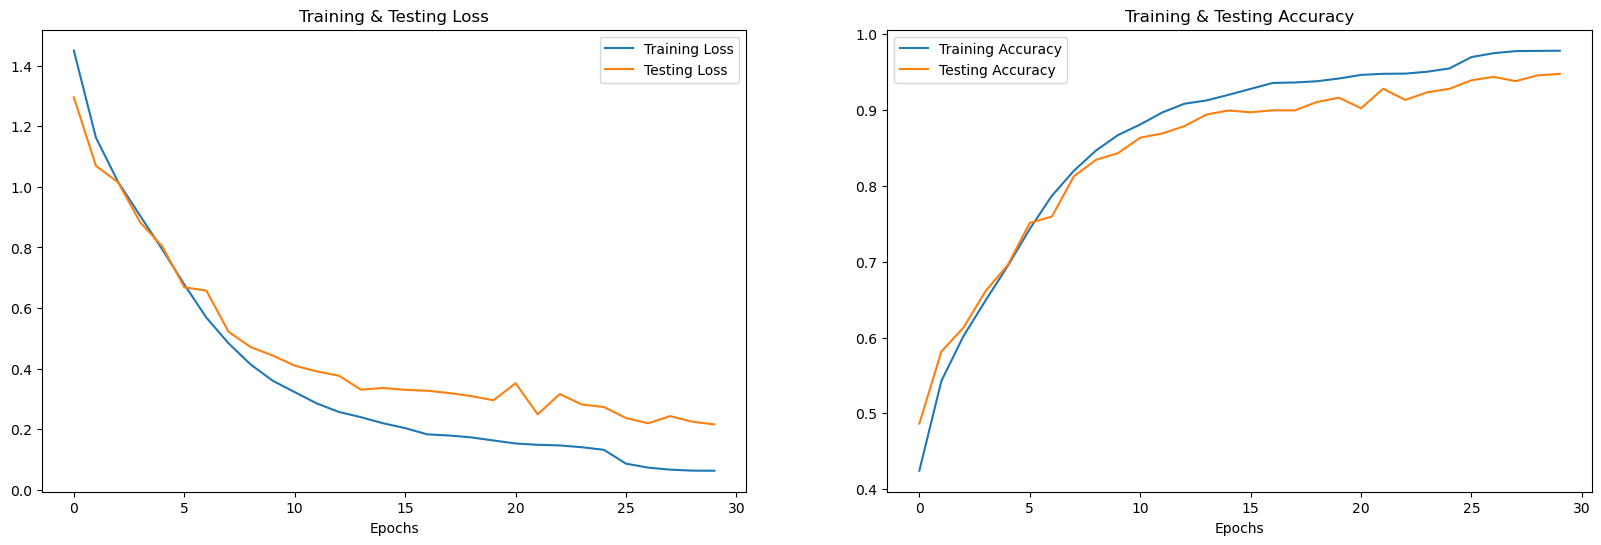

In [25]:
print("Accuracy of our model on test data : " , model.evaluate(x_test_cnn,y_test)[1]*100 , "%")

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

## **Metrics**

Now that we have trained the model, we will evaluate its performance by calculating some metrics.

- Accuracy
- Precision
- Recall
- F1 score

### **Load packages**

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import seaborn as sns

### **Load Model**

As we saved the best weights in a `.h5` file, we're going to load them into the model architecture.

In [27]:
hyperparams = './weights/weights.keras'
mod = load_model(hyperparams)

In [28]:
y_pred = mod.predict(x_test_cnn)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [29]:
# F1-score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')  
print("F1-score:", f1)

# Accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
print("Recall:", recall)


F1-score: 0.9478062628683345
Accuracy: 0.9477903391572456
Precision: 0.9479086052031954
Recall: 0.9477903391572456


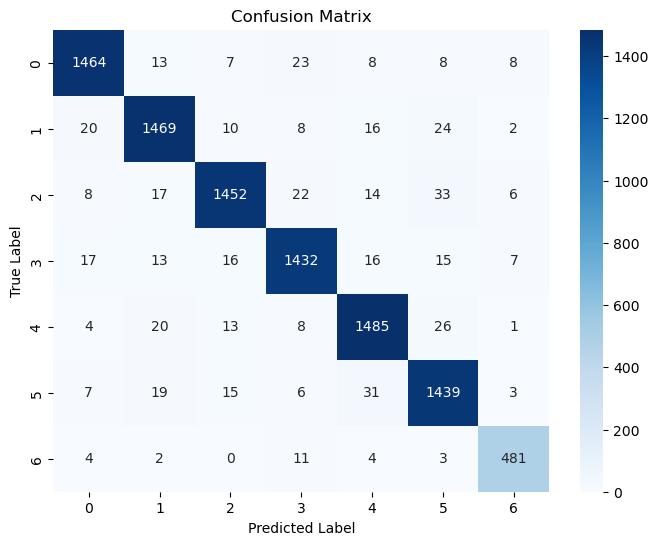

In [30]:
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **KFolds | Cross-validation**

In [31]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

In [32]:
def build_model(input_shape):
    
    model = tf.keras.Sequential([
        
        Input(shape=input_shape),

        Conv1D(256, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(7, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [33]:
def cross_validate_cnn(X, Y, build_fn, k_folds=5, epochs=30, batch_size=32):
    
    """

        Aplica K-Fold Cross Validation a un modelo CNN en Keras.

        Params:
        - X: Datos de entrada (numpy array de forma (num_samples, timesteps, features))
        - Y: Etiquetas en formato one-hot encoding
        - build_fn: Función que devuelve un modelo Keras
        - k_folds: Número de particiones (default=5)
        - epochs: Número de épocas (default=10)
        - batch_size: Tamaño del batch (default=32)


    """

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []


    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        print(f"\nTraining Fold {fold + 1}/{k_folds}...")

        X_train, X_val = X[train_idx], X[val_idx]
        Y_train, Y_val = Y[train_idx], Y[val_idx]

        model = build_fn(input_shape=(X_train.shape[1], 1))

        lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
        mc = ModelCheckpoint(f'./weights/weights_fold_{fold+1}.keras', monitor='val_accuracy', save_best_only=True)

        model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[lrr, mc])

        _, val_accuracy = model.evaluate(X_val, Y_val)

        print(f"Fold {fold + 1} | Accuracy: {val_accuracy:.4f}")

        fold_accuracies.append(val_accuracy)


    mean_accuracy = np.mean(fold_accuracies)
    print(f"\nMean Accuracy across {k_folds} folds: {mean_accuracy:.4f}")

    return fold_accuracies

In [34]:
x_train_cnn.shape, y_train.shape, x_test_cnn.shape, y_test.shape

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [35]:
# X_kf_small = x_train_cnn[:1000]
# Y_small = y_train[:1000]
# X_kf_small.shape, Y_small.shape

In [36]:
n_epochs = 30 # should be 30
kfolds = 5

In [37]:
accuracies = cross_validate_cnn(
                                x_train_cnn, 
                                y_train, 
                                build_model, 
                                k_folds=kfolds, 
                                epochs=n_epochs, 
                                batch_size=32
                            )


Training Fold 1/5...
Epoch 1/30
973/973 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.3443 - loss: 1.6213 - val_accuracy: 0.5233 - val_loss: 1.2120 - learning_rate: 0.0010
Epoch 2/30
973/973 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.5509 - loss: 1.1714 - val_accuracy: 0.5930 - val_loss: 1.0511 - learning_rate: 0.0010
Epoch 3/30
973/973 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.6046 - loss: 1.0133 - val_accuracy: 0.6350 - val_loss: 0.9551 - learning_rate: 0.0010
Epoch 4/30
973/973 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6563 - loss: 0.8947 - val_accuracy: 0.6575 - val_loss: 0.8986 - learning_rate: 0.0010
Epoch 5/30
973/973 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7085 - loss: 0.7682 - val_accuracy: 0.7026 - val_loss: 0.7939 - learning_rate: 0.0010
Epoch 6/30
973/973 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.7576 - loss: 0.6556 - val_accuracy: 0.7391 - val_loss: 0.7071 - learning_rate: 0.0010
Epoch 7/30
973/973 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step 

In [38]:
model_1 = load_model('./weights/weights_fold_1.keras')
model_2 = load_model('./weights/weights_fold_2.keras')
model_3 = load_model('./weights/weights_fold_3.keras')
model_4 = load_model('./weights/weights_fold_4.keras')
model_5 = load_model('./weights/weights_fold_5.keras')

In [39]:
def predict(model, x_test_cnn, idx=1):

    print(f"Predicting with model {idx}...")
    
    y_pred = model.predict(x_test_cnn)
    y_pred_labels = np.argmax(y_pred, axis=1)

    return y_pred_labels

In [40]:
y_pred_1 = predict(model_1, x_test_cnn, idx=1)
y_pred_2 = predict(model_2, x_test_cnn, idx=2)
y_pred_3 = predict(model_3, x_test_cnn, idx=3)
y_pred_4 = predict(model_4, x_test_cnn, idx=4)
y_pred_5 = predict(model_5, x_test_cnn, idx=5)

Predicting with model 1...
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicting with model 2...
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicting with model 3...
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicting with model 4...
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicting with model 5...
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [41]:
def get_metrics(y_labels, y_pred, idx=1):

    f1 = f1_score(y_labels, y_pred, average='weighted')  
    accuracy = accuracy_score(y_labels, y_pred)
    precision = precision_score(y_labels, y_pred, average='weighted')
    recall = recall_score(y_labels, y_pred, average='weighted')
    cm = confusion_matrix(y_labels, y_pred)


    print(f"Metrics for model {idx}")
    print("F1-score:", f1)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n")

    #return f1, accuracy, precision, recall

Metrics for model 1
F1-score: 0.9124641169560417
Accuracy: 0.9124357656731757
Precision: 0.9128460605203836
Recall: 0.9124357656731757


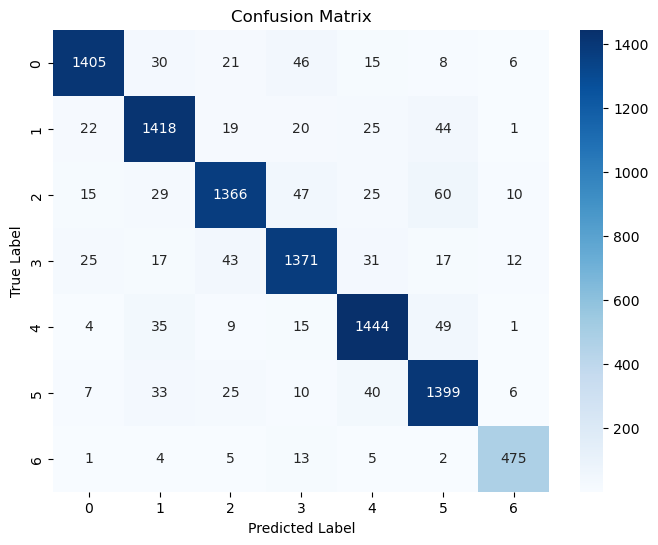



Metrics for model 2
F1-score: 0.8913734774854278
Accuracy: 0.8915724563206577
Precision: 0.8926817188413184
Recall: 0.8915724563206577


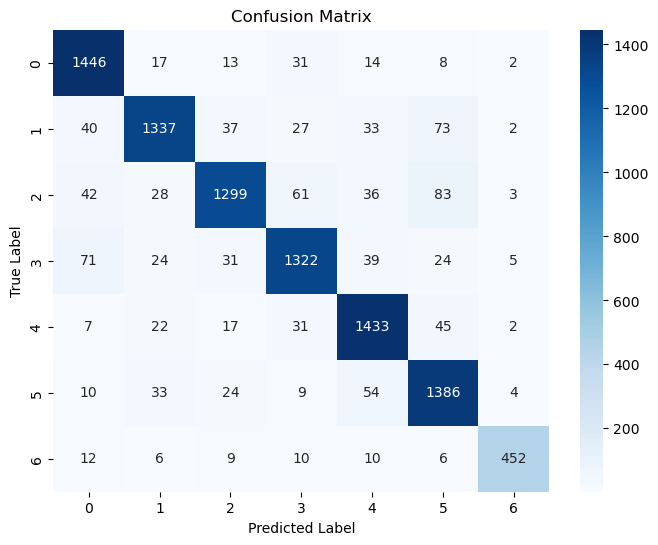



Metrics for model 3
F1-score: 0.9123674464149415
Accuracy: 0.912332990750257
Precision: 0.9127873184418192
Recall: 0.912332990750257


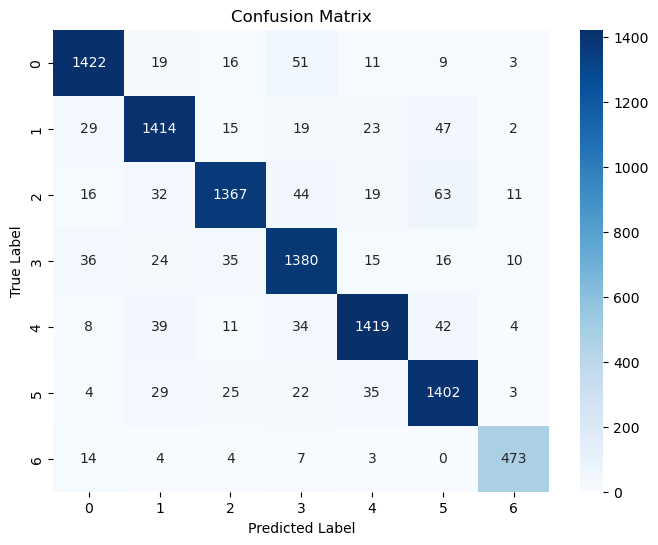



Metrics for model 4
F1-score: 0.8701210617934645
Accuracy: 0.8700924974306269
Precision: 0.8708064122564302
Recall: 0.8700924974306269


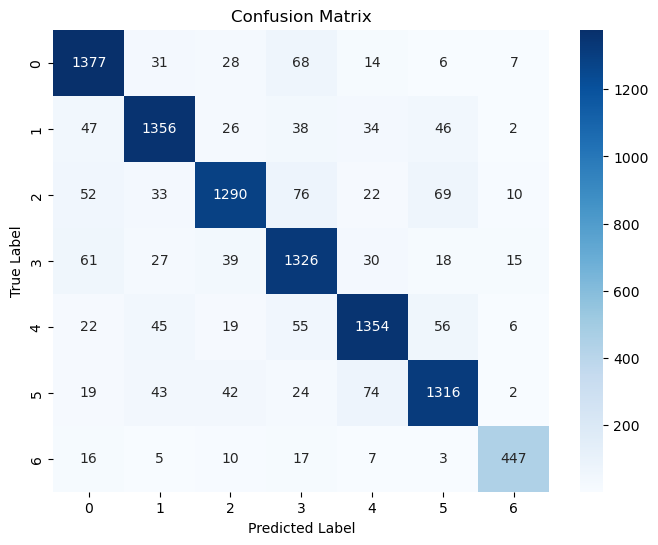



Metrics for model 5
F1-score: 0.8954636727176049
Accuracy: 0.8955806783144913
Precision: 0.8964217394265055
Recall: 0.8955806783144913


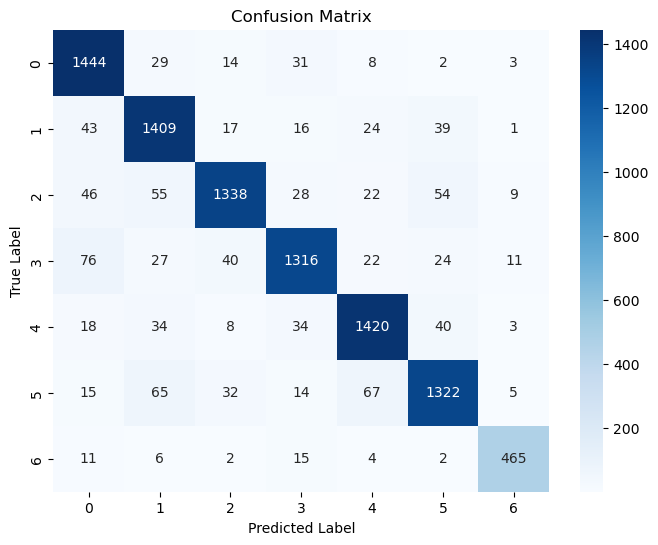

In [42]:
get_metrics(y_test_labels, y_pred_1, idx=1)
get_metrics(y_test_labels, y_pred_2, idx=2)
get_metrics(y_test_labels, y_pred_3, idx=3)
get_metrics(y_test_labels, y_pred_4, idx=4)
get_metrics(y_test_labels, y_pred_5, idx=5)
